# TF Model training script

## Imports and other initializations

In [1]:
# fairing:include-cell
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import numpy as np
import sys
import os
from pathlib import Path
import pandas as pd
from kubeflow import fairing 
import time
import json
import logging
import imp
import yaml
import seaborn as sns
import shutil
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import normalize
from google.cloud import storage
from tensorflow.io import FixedLenFeature

from matplotlib import pyplot as plt

sys.path.append('../utilities/')
import modeldb_tf_utilities
import evaluation_utilities
import model_utilities
import from_tfrecords
imp.reload(modeldb_tf_utilities)
imp.reload(evaluation_utilities)
imp.reload(model_utilities)
imp.reload(from_tfrecords)

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
# fairing:include-cell
# Global configs that would be used at all the steps of the notebook.
GCP_PROJECT = fairing.backends.gcp.guess_project_name()
NAMESPACE = fairing.backends.utils.get_current_k8s_namespace()
PROJECT_ID = GCP_PROJECT
MODELDB_CLIENT_URL = "https://modeldb.mlp.ml.gce.z8s.io/"
print(NAMESPACE)
print(GCP_PROJECT)

rmenon
zulilymodeltraining


## Configuration Parameters

### Model and Data Related

In [3]:
# fairing:include-cell
# YAML file containing model data configuration: i.e. Feature names, identification of categorical names etc
model_data_config_file_name = "./../model_configs/text_based_tfrecord_config.yaml"

# Dataset paths
data_config = {
    #"training":'gs://zulilymodeltraining/rmenon/data/tf_records/train/',
    "training":'gs://zulilymodeltraining/prgupta/test_2',
    "validation":'gs://zulilymodeltraining/prgupta/test_2',
    "test":'gs://zulilymodeltraining/prgupta/test_2',
}

# Path to save trained model and other model-related specs
model_data_path_prefix= f"gs://personalization-tensorflow/models/text_features/"

# Model training parameters
model_fit_config = {
    "batch_size": 2048,
    "initial_lr": 1e-3,
    "epochs": 6,
    "shuffle_buffer_size": 16384,
}

# Evaluating LTR performance metrics
max_rank = 15

# Use distributed training across GPUs (only set to True if using >1GPU). Also only efficient for large models.
use_distributed_training = False

# Use checkpointed model (usually based on lowest validation loss) to generate validation metrics
use_checkpointed_model = True

# Run locally for testing
run_local = True

# compression_type_for_tfrecord
compression_type = 'GZIP'

### Feature Normalizer Related

In [4]:
# fairing:include-cell
# Parameters related to feature normalizer for the model
num_samples_to_train_normalizer = 500 # Set a sample size (in terms of number of batches). If set to None, the entire "training" set will be used to train the normalizer.
if run_local:
    num_samples_to_train_normalizer = 1

### Model DB Related

In [5]:
# fairing:include-cell
# Model DB configuration parameters
modeldb_config = {
    ## Required configs
    # These are required configs for a modeldb run. 
    # Please refer to notes here: https://confluence.zulily.com/display/tech/Notes+about+using+ModelDB if you are updaing the default
    # project and experiment name.
    "client_url": MODELDB_CLIENT_URL,
    "project_name": 'P13N_Event_Sort_Models_2021',
    "experiment_name": f"text-features",
    # Username is mapped into as a ModelDB tag which will help to identiy a run by an user.
    "username": NAMESPACE,
    
    ## Optional configs
    # If an experiment run name is not specified, then ModelDB will randomly assign a run_name.
    "experiment_run_name": 'tf_record_format',#'4layer_1024_target_0_458_dataset_v4',
    # This parameter is by default true and is required if you are going to run multiple runs with same experiment_run_name.
    # This will prevent you from overwritng an experiment_run data and create a new run everytime a pipeline runs.
    "add_random_hash_to_run_name": 'true'
}

### Model Internal initializations based on YAML configuration

In [6]:
# fairing:include-cell
# Retrieve model configuration from YAML file.
with open(model_data_config_file_name) as file:
    model_data_config = yaml.load(file, Loader=yaml.SafeLoader)
# Do some name mappings to make code cleaner
feature_names = model_data_config['feature_names']
categorical_columns = model_data_config['categorical_columns']
categorical_columns_vocabulary_list = model_data_config['categorical_columns_vocabulary_list']
numeric_columns_to_norm = model_data_config['numeric_columns_to_norm']
vector_features = model_data_config['vector_columns']
numeric_columns_remaining = [xx for xx in feature_names if ((xx not in categorical_columns) \
                                                            and (xx not in numeric_columns_to_norm)\
                                                            and (xx not in vector_features))]
vector_column_lengths = model_data_config['vector_column_lengths']
target_name = model_data_config['target_name']
numeric_columns_remaining.remove(target_name)

## Create/ Load a Feature Normalizer

In [7]:
# fairing:include-cell
def google_file_path_exists(path_name):
    """
    Checks if a file path exists in google storage
    path_name should be something like 'gs://zulilymodeltraining/rmenon/tf-models-data/normalizer_models/saved_model.pb'
    """    

    storage_client = storage.Client()
    interim = path_name.split('//') # Extract gs:
    interim = interim[1].split('/') # Extract stuff after gs, 'zulilymodeltraining/rmenon/tf-models-data/normalizer_models/saved_model.pb'
    bucket_name = interim[0] # Extract bucket name, 'zulilymodeltraining'
    name = ('/').join(interim[1:]) #Create file path excluding bucket name, 'rmenon/tf-models-data/normalizer_models/saved_model.pb'
    bucket = storage_client.bucket(bucket_name)
    stats = storage.Blob(bucket=bucket, name=name).exists(storage_client)
    return(stats)

In [8]:
# fairing:include-cell
st = time.time()

normalizer_schema = {}
for feature in numeric_columns_to_norm:
    normalizer_schema[feature] = float
    
# reate a data generator to run thru the training data for normalizing features
data_batches_for_norm = from_tfrecords.from_tfrecords_to_ds(data_config['training'], \
                                                            compression_type = compression_type,\
                                                            schema=normalizer_schema)\
                        .batch(2048)

# Pick a random sample if specified
if num_samples_to_train_normalizer is not None:
    data_batches_for_norm = data_batches_for_norm.take(int(num_samples_to_train_normalizer))

# Stack features: Change from dictionary format to a a stacked tensor array
def stack_features(features):
    return tf.stack(list(features.values()), axis=1)
data_batches_for_norm_stacked = data_batches_for_norm.map(stack_features)


# Train the normalizer 
if use_distributed_training:
    mirrored_strategy = tf.distribute.MirroredStrategy()
    with mirrored_strategy.scope():
        feature_normalizer = preprocessing.Normalization()
        feature_normalizer.adapt(data_batches_for_norm_stacked)
else:
    feature_normalizer = preprocessing.Normalization()
    feature_normalizer.adapt(data_batches_for_norm_stacked)
print('Normalizer training took {}secs'.format(time.time() - st))

Normalizer training took 1.3728408813476562secs


In [9]:
feature_normalizer

## Model Helper functions

In [10]:
# fairing:include-cell
# Model-DB logging functions
def log_model_attributes(modeldb_expt_run):
    """
    Capturing Model attributes before starting training in ModelDB.
    """
    modeldb_expt_run.log_hyperparameters(model_fit_config)
    modeldb_expt_run.log_attributes(data_config)
    modeldb_expt_run.log_attributes(model_data_config)

    
def log_model_metrics(modeldb_expt_run, model, model_save_path, model_checkpoint_path, test_ds = None):
    """
    Capturing Model metrics at the end of training in ModelDB.
    """
    
    # Log the paths where the model and related data were saved
    modeldb_expt_run.log_artifact_path('other_model_related_data_path', model_data_path_prefix)
    modeldb_expt_run.log_artifact_path('model_save_path', model_save_path)
    modeldb_expt_run.log_artifact_path('model_checkpoint_path', model_checkpoint_path)
    
    # Log accuracy of the supplied data set (if supplied)
    if test_ds is not None:
        loss, accuracy, precision, recall = model.evaluate(test_ds)        
        modeldb_expt_run.log_metric('loss_', loss)
        modeldb_expt_run.log_metric('accuracy', accuracy)
        modeldb_expt_run.log_metric('precision', precision)
        modeldb_expt_run.log_metric('recall', recall)
        

def log_model_summary(modeldb_expt_run, model):
    """
    Log the structure of the Model
    """
    stringlist = []
    # Only store the last sequential layer
    model.get_layer(index=-1).summary(print_fn=lambda x: stringlist.append(x))
    short_model_summary = "\n".join(stringlist)    
    
    if os.path.exists('/tmp/model/'):        
        shutil.rmtree('/tmp/model')
    os.mkdir('/tmp/model')

    with open('/tmp/model/model.txt', 'w') as f:
        f.write(short_model_summary)
    f.close()
    modeldb_expt_run.log_artifact('Model_Summary', '/tmp/model/model.txt')    

In [11]:
# fairing:include-cell
# Target variable mapping function
def parse_label_from_data(data):
    """
    Function to map the data parsed in order to generate the labels
    """
    labels = data.pop(target_name)
    
    label_0_values = tf.constant(['0'], dtype=tf.dtypes.string)    
    labels = tf.reshape(labels, [-1, 1])
    labels_converted = tf.where(tf.reduce_any(tf.equal(labels, label_0_values), axis=1), 
                              tf.constant(0, dtype=tf.dtypes.int64), 
                              tf.constant(1, dtype=tf.dtypes.int64)) 
    return data, labels_converted

## Model Setup and training

In [12]:
# fairing:include-cell
# Get training, test and validation data generators
training_data = from_tfrecords.from_tfrecords_to_ds(data_config['training'], compression_type = compression_type,) \
        .map(parse_label_from_data, num_parallel_calls=AUTOTUNE) \
        .shuffle(model_fit_config['shuffle_buffer_size']).batch(model_fit_config['batch_size'])
training_data = training_data.prefetch(buffer_size=AUTOTUNE)

validation_data = from_tfrecords.from_tfrecords_to_ds(data_config['validation'], compression_type = compression_type,) \
        .map(parse_label_from_data, num_parallel_calls=AUTOTUNE) \
        .batch(model_fit_config['batch_size'])
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)

test_data = from_tfrecords.from_tfrecords_to_ds(data_config['test'], compression_type = compression_type,) \
        .map(parse_label_from_data, num_parallel_calls=AUTOTUNE) \
        .batch(model_fit_config['batch_size'])
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

if run_local:
    # For testing purposes: Selects just 1 batch of data for training, validation and test
    training_data = training_data.take(1)
    validation_data = validation_data.take(1)
    test_data = test_data.take(1)
else:
    # Using just 1/10th dataset for training and validation
    #training_data = training_data.shard(10, 1) 
    validation_data = validation_data.shard(10, 1)

In [13]:
# fairing:include-cell
initial_lr = model_fit_config['initial_lr']
num_epochs = model_fit_config['epochs']

# Create Model-DB Instance
modeldb_expt_run = modeldb_tf_utilities.create_modeldb_experiment_run(modeldb_config)

# Get callbacks and save paths
model_data_path_prefix = os.path.join(model_data_path_prefix, modeldb_expt_run.name)
callbacks = modeldb_tf_utilities.get_tf_callbacks(modeldb_expt_run, model_data_path_prefix)

# Save some attributes before training starts
log_model_attributes(modeldb_expt_run)

# Define model 
#loss=tf.keras.losses.BinaryCrossentropy(from_logits=False)
loss=tf.keras.losses.MeanSquaredError()
optimizer=tf.optimizers.Adam(learning_rate=initial_lr)

# Create a distribution strategy to run on multiple GPUs
if use_distributed_training:
    with mirrored_strategy.scope():
        sort_model = model_utilities.get_tfrecord_sort_model(feature_normalizer, 
                                                       numeric_columns_to_norm, 
                                                       numeric_columns_remaining, 
                                                       categorical_columns,
                                                       categorical_columns_vocabulary_list,
                                                       vector_features,
                                                        vector_column_lengths)
        sort_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
else:
    sort_model = model_utilities.get_tfrecord_sort_model(feature_normalizer,
                                                   numeric_columns_to_norm, 
                                                   numeric_columns_remaining, 
                                                   categorical_columns,
                                                   categorical_columns_vocabulary_list,
                                                    vector_features,
                                                    vector_column_lengths)
    sort_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

log_model_summary(modeldb_expt_run, sort_model)

connection successfully established
got existing Project: P13N_Event_Sort_Models_2021
got existing Experiment: text-features
created new ExperimentRun: tf_record_format_589xap8a
upload complete (Model_Summary)


In [14]:
sort_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
estimated_demand (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
projected_demand (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
demand_to_date_norm (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
order_ct_to_date_norm (InputLay [(None, 1)]          0                                            
______________________________________________________________________________________________

In [15]:
# fairing:include-cell
# Start the training process
try:
    start_time = time.time()  
    #cached_ds = training_data.cache()
    #cached_validation_ds = validation_data.cache()
    # Fit the model
    model_history = sort_model.fit(training_data, validation_data=validation_data, epochs=num_epochs, callbacks=callbacks)
    # Log time taken to fit model
    modeldb_expt_run.log_metric('model_fit_run_duration_in_secs', (time.time() - start_time))            
    # Save Model
    model_save_path = os.path.join(model_data_path_prefix, 'saved_model/')
    sort_model.save(model_save_path)
    # But reload model from checkpoint (lowest validation loss) to generate validation performance
    model_checkpoint_path = os.path.join(model_data_path_prefix, 'checkpoints/')
    if use_checkpointed_model:
        # But reload model from checkpoint (lowest validation loss) to generate validation performance        
        sort_model.load_weights(model_checkpoint_path)    
    # Log other metrics from model including validation data performance
    log_model_metrics(modeldb_expt_run, sort_model, model_save_path, model_checkpoint_path, validation_data)
    modeldb_expt_run.log_tag('success')
except:
    modeldb_expt_run.log_tag('failed_run')
    raise

Epoch 1/6


/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:588: UserWarning: Input dict contained keys ['customer_id', 'event_id', 'event_position', 'new_today', 'send_date'] which did not match any model input. They will be ignored by the model.
  warnings.warn(
[W 211209 04:23:51 functional:632] Model was constructed with shape (None, 20) for input KerasTensor(type_spec=TensorSpec(shape=(None, 20), dtype=tf.float32, name='cust_msrp_iqr_ppt'), name='cust_msrp_iqr_ppt', description="created by layer 'cust_msrp_iqr_ppt'"), but it was called on an input with incompatible shape (None, 1).


[W 211209 04:23:51 functional:632] Model was constructed with shape (None, 20) for input KerasTensor(type_spec=TensorSpec(shape=(None, 20), dtype=tf.float32, name='cust_msrp_median_ppt'), name='cust_msrp_median_ppt', description="created by layer 'cust_msrp_median_ppt'"), but it was called on an input with incompatible shape (None, 1).


[W 211209 04:23:51 functional:632] Model was constructed with shape (None, 20) for input KerasTensor(type_spec=TensorSpec(shape=(None, 20), dtype=tf.float32, name='cust_price_iqr_ppt'), name='cust_price_iqr_ppt', description="created by layer 'cust_price_iqr_ppt'"), but it was called on an input with incompatible shape (None, 1).


[W 211209 04:23:51 functional:632] Model was constructed with shape (None, 20) for input KerasTensor(type_spec=TensorSpec(shape=(None, 20), dtype=tf.float32, name='cust_price_median_ppt'), name='cust_price_median_ppt', description="created by layer 'cust_price_median_ppt'"), but it was called on an input with incompatible shape (None, 1).


[W 211209 04:23:51 functional:632] Model was constructed with shape (None, 8) for input KerasTensor(type_spec=TensorSpec(shape=(None, 8), dtype=tf.float32, name='customer_age'), name='customer_age', description="created by layer 'customer_age'"), but it was called on an input with incompatible shape (None, 1).


[W 211209 04:23:51 functional:632] Model was constructed with shape (None, 4) for input KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='customer_gender'), name='customer_gender', description="created by layer 'customer_gender'"), but it was called on an input with incompatible shape (None, 1).


[W 211209 04:23:51 functional:632] Model was constructed with shape (None, 8) for input KerasTensor(type_spec=TensorSpec(shape=(None, 8), dtype=tf.float32, name='event_age'), name='event_age', description="created by layer 'event_age'"), but it was called on an input with incompatible shape (None, 1).


[W 211209 04:23:51 functional:632] Model was constructed with shape (None, 4) for input KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='event_gender'), name='event_gender', description="created by layer 'event_gender'"), but it was called on an input with incompatible shape (None, 1).


[W 211209 04:23:51 functional:632] Model was constructed with shape (None, 100) for input KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name='text_embd_cart_adds'), name='text_embd_cart_adds', description="created by layer 'text_embd_cart_adds'"), but it was called on an input with incompatible shape (None, 1).


[W 211209 04:23:51 functional:632] Model was constructed with shape (None, 100) for input KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name='text_embd_event'), name='text_embd_event', description="created by layer 'text_embd_event'"), but it was called on an input with incompatible shape (None, 1).


[W 211209 04:23:51 functional:632] Model was constructed with shape (None, 100) for input KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name='text_embd_style_views'), name='text_embd_style_views', description="created by layer 'text_embd_style_views'"), but it was called on an input with incompatible shape (None, 1).


[W 211209 04:23:52 functional:632] Model was constructed with shape (None, 20) for input KerasTensor(type_spec=TensorSpec(shape=(None, 20), dtype=tf.float32, name='cust_msrp_iqr_ppt'), name='cust_msrp_iqr_ppt', description="created by layer 'cust_msrp_iqr_ppt'"), but it was called on an input with incompatible shape (None, 1).


[W 211209 04:23:52 functional:632] Model was constructed with shape (None, 20) for input KerasTensor(type_spec=TensorSpec(shape=(None, 20), dtype=tf.float32, name='cust_msrp_median_ppt'), name='cust_msrp_median_ppt', description="created by layer 'cust_msrp_median_ppt'"), but it was called on an input with incompatible shape (None, 1).


[W 211209 04:23:52 functional:632] Model was constructed with shape (None, 20) for input KerasTensor(type_spec=TensorSpec(shape=(None, 20), dtype=tf.float32, name='cust_price_iqr_ppt'), name='cust_price_iqr_ppt', description="created by layer 'cust_price_iqr_ppt'"), but it was called on an input with incompatible shape (None, 1).


[W 211209 04:23:52 functional:632] Model was constructed with shape (None, 20) for input KerasTensor(type_spec=TensorSpec(shape=(None, 20), dtype=tf.float32, name='cust_price_median_ppt'), name='cust_price_median_ppt', description="created by layer 'cust_price_median_ppt'"), but it was called on an input with incompatible shape (None, 1).


[W 211209 04:23:52 functional:632] Model was constructed with shape (None, 8) for input KerasTensor(type_spec=TensorSpec(shape=(None, 8), dtype=tf.float32, name='customer_age'), name='customer_age', description="created by layer 'customer_age'"), but it was called on an input with incompatible shape (None, 1).


[W 211209 04:23:52 functional:632] Model was constructed with shape (None, 4) for input KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='customer_gender'), name='customer_gender', description="created by layer 'customer_gender'"), but it was called on an input with incompatible shape (None, 1).


[W 211209 04:23:52 functional:632] Model was constructed with shape (None, 8) for input KerasTensor(type_spec=TensorSpec(shape=(None, 8), dtype=tf.float32, name='event_age'), name='event_age', description="created by layer 'event_age'"), but it was called on an input with incompatible shape (None, 1).


[W 211209 04:23:52 functional:632] Model was constructed with shape (None, 4) for input KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='event_gender'), name='event_gender', description="created by layer 'event_gender'"), but it was called on an input with incompatible shape (None, 1).


[W 211209 04:23:52 functional:632] Model was constructed with shape (None, 100) for input KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name='text_embd_cart_adds'), name='text_embd_cart_adds', description="created by layer 'text_embd_cart_adds'"), but it was called on an input with incompatible shape (None, 1).


[W 211209 04:23:52 functional:632] Model was constructed with shape (None, 100) for input KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name='text_embd_event'), name='text_embd_event', description="created by layer 'text_embd_event'"), but it was called on an input with incompatible shape (None, 1).


[W 211209 04:23:52 functional:632] Model was constructed with shape (None, 100) for input KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name='text_embd_style_views'), name='text_embd_style_views', description="created by layer 'text_embd_style_views'"), but it was called on an input with incompatible shape (None, 1).


InvalidArgumentError:  Key: text_embd_style_views.  Can't parse serialized Example.
	 [[{{node ParseSingleExample/ParseExample/ParseExampleV2}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_3437]

Function call stack:
train_function


## Evaluate Performance of Model

In [204]:
# fairing:include-cell
st = time.time()

# Get predicted labels for validation data
pred_indices_raw = sort_model.predict(validation_data, verbose=1)
pred_indices = (pred_indices_raw > 0.5)

# Get true labels for test data
iterator = validation_data.as_numpy_iterator()
true_labels = np.array([])
for x in iterator:
    true_labels = np.append(true_labels, x[-1])
print("Time taken for generating labels is {}secs".format(time.time() - st))

/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:588: UserWarning: Input dict contained keys ['customer_id', 'event_id', 'event_position', 'new_today', 'send_date'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


1/1 [==============================] - 2s 2s/step
Time taken for generating labels is 2.773676633834839secs


In [205]:
print('I am here')

I am here


              precision    recall  f1-score   support

     class 0       0.65      0.86      0.74      1011
     class 1       0.80      0.56      0.65      1037

    accuracy                           0.70      2048
   macro avg       0.73      0.71      0.70      2048
weighted avg       0.73      0.70      0.70      2048

upload complete (ROC)
upload complete (PR)
upload complete (confusion_matrix)
upload complete (confusion_matrix_normalized)


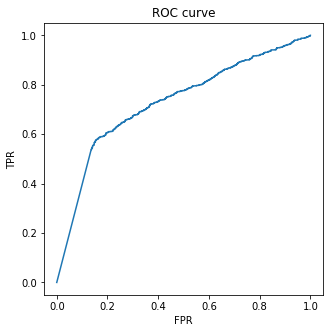

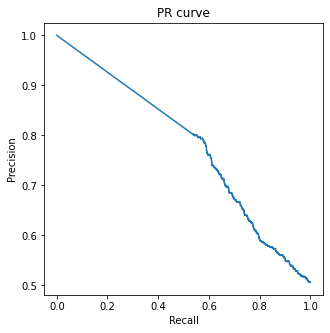

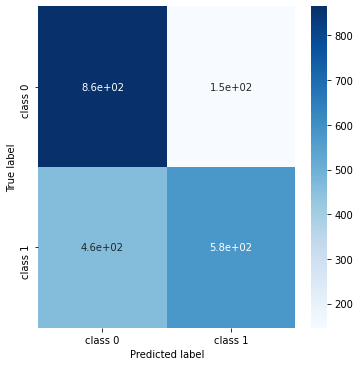

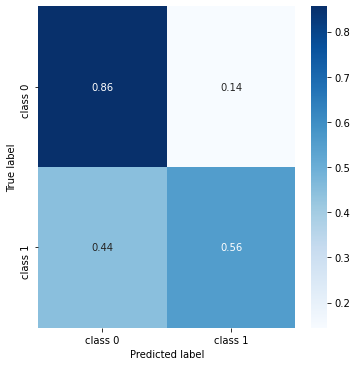

In [206]:
# fairing:include-cell
# Making sure directory is removed if already exists
if os.path.exists('/tmp/plots'):        
    shutil.rmtree('/tmp/plots')
os.mkdir('/tmp/plots')

target_names = ['class 0', 'class 1']

# Print Some Performance Metrics
print(classification_report(true_labels, pred_indices, target_names = target_names, zero_division = 0))
cr = classification_report(true_labels, pred_indices, target_names = target_names, zero_division=0, output_dict = True)
class_0_recall = np.around(cr['class 0']['recall'], decimals=5)
class_1_recall = np.around(cr['class 1']['recall'], decimals=5)
modeldb_expt_run.log_metrics({'Recall_Class_0': class_0_recall, 'Recall_Class_1': class_1_recall, })


# Create ROC curve
figure = plt.figure(figsize=(5, 5))
fpr, tpr, thresholds = roc_curve(true_labels, pred_indices_raw)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.savefig('/tmp/plots/roc.png')
modeldb_expt_run.log_artifact('ROC', '/tmp/plots/roc.png')

# Create PR curve
figure = plt.figure(figsize=(5, 5))
precision, recall, thresholds = precision_recall_curve(true_labels, pred_indices_raw)
plt.plot(recall, precision)
plt.title('PR curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.savefig('/tmp/plots/pr.png')
modeldb_expt_run.log_artifact('PR', '/tmp/plots/pr.png')


# Create confusion matrix
cm = confusion_matrix(true_labels, pred_indices)
cm_df = pd.DataFrame(cm, index = target_names, columns = target_names)
cm_normalize_df = pd.DataFrame(normalize(cm, 'l1', axis = 1), index = target_names, columns = target_names)
figure = plt.figure(figsize=(5, 5))
svm = sns.heatmap(cm_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
figure = svm.get_figure()    
figure.savefig('/tmp/plots/cm.png')

figure = plt.figure(figsize=(5, 5))
svm = sns.heatmap(cm_normalize_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
figure = svm.get_figure()    
figure.savefig('/tmp/plots/cm_norm.png')

# Saving confusion_matrix
modeldb_expt_run.log_artifact('confusion_matrix', '/tmp/plots/cm.png')
modeldb_expt_run.log_artifact('confusion_matrix_normalized', '/tmp/plots/cm_norm.png')

In [207]:
# fairing:include-cell
# Get LTR Metrics on a test-data set
if os.path.exists('/tmp/data'):        
    shutil.rmtree('/tmp/data')
os.mkdir('/tmp/data')

# Get predictions from the model
st = time.time()
model_predictions = sort_model.predict(test_data, verbose=1)
print('Process took {}secs'.format(time.time() - st))

# Construct a pandas dataframe with scores and target
st = time.time()
model_results_df = pd.DataFrame()
for f, t in test_data:
    temp = pd.DataFrame()
    temp[target_name] = t
    temp['customer_id'] = f['customer_id']
    model_results_df = model_results_df.append(temp)
print('Process took {}secs'.format(time.time() - st))
model_results_df['predicted'] = model_predictions
prediction_column = 'predicted'

# Call the function to evaluate LTR metrics
model_metrics = pd.DataFrame()
model_hit_rate, model_ndcg = evaluation_utilities.get_ltr_metrics(model_results_df, 
                                                                         max_rank, 
                                                                         target_name, 
                                                                         prediction_column)

model_metrics['hit_rate'] = model_hit_rate
model_metrics['ndcg'] = model_ndcg

modeldb_expt_run.log_metrics({'HR_10': model_hit_rate[9], 'NDCG_10': model_ndcg[9]})
model_metrics.to_csv(f'/tmp/data/{modeldb_expt_run.name}.csv')
modeldb_expt_run.log_artifact('LTRMetrics', f'/tmp/data/{modeldb_expt_run.name}.csv')

/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:588: UserWarning: Input dict contained keys ['customer_id', 'event_id', 'event_position', 'new_today', 'send_date'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


UnimplementedError:  Cast int64 to string is not supported
	 [[node model_12/Cast (defined at <ipython-input-207-dfdef1f1ce28>:9) ]] [Op:__inference_predict_function_81440]

Function call stack:
predict_function


In [ ]:
# fairing:include-cell
modeldb_expt_run.log_metric('experiment_run_duration_in_secs', (time.time() - start_time))            

### Run below cells to get information about the model

In [ ]:
#a_sort_model = get_sort_model(feature_normalizer)

In [ ]:
#a_sort_model.summary()

In [ ]:
#sort_model.get_layer(index=-1).summary()

In [ ]:
#sort_model.summary()

In [ ]:
#sort_model.get_layer(index=-1).summary()

### Run Below to evaluate model from checkpoint

In [ ]:
errout

In [ ]:
a_sort_model = get_sort_model(numeric_preprocessor=feature_normalizer)

In [ ]:
model_save_path = 'gs://personalization-tensorflow/models/text_features/4layer_1024_target_0_458_correct_age_gender_jqgdjbdo'
checkpoint_path = os.path.join(model_save_path, 'checkpoints/')

In [ ]:
a_sort_model.load_weights(checkpoint_path)

In [ ]:
# Get predictions from the model
st = time.time()
model_predictions = a_sort_model.predict(test_data, verbose = 1)
print('Process took {}secs'.format(time.time() - st))

# Construct a pandas dataframe with scores and target
st = time.time()
model_results_df = pd.DataFrame()
for f, t in test_data:
    temp = pd.DataFrame()
    temp[target_name] = t
    temp['customer_id'] = f['customer_id']
    model_results_df = model_results_df.append(temp)
print('Process took {}secs'.format(time.time() - st))
model_results_df['predicted'] = model_predictions
prediction_column = 'predicted'

# Call the function to evaluate LTR metrics
model_metrics = pd.DataFrame()
model_hit_rate, model_ndcg = evaluation_utilities.get_ltr_metrics(model_results_df, 
                                                                         max_rank, 
                                                                         target_name, 
                                                                         prediction_column)

model_metrics['hit_rate'] = model_hit_rate
model_metrics['ndcg'] = model_ndcg

In [ ]:
## Compare with BS Results
file_path_to_bs_results = "bs_results_on_test_test_v2.csv"
bs_model_metrics = pd.read_csv(file_path_to_bs_results)

In [ ]:
plt.figure()
plt.plot(np.arange(1,max_rank), model_metrics['hit_rate'], '*-', label='Text based model')
plt.plot(np.arange(1,max_rank), bs_model_metrics['hit_rate'], '*-', label='Estimated-demand based model')
plt.ylabel('HR@K')
plt.xlabel('K')
plt.grid(b=True)
plt.legend()

plt.figure()
plt.plot(np.arange(1,max_rank), model_metrics['ndcg'], '*-', label='Text based model')
plt.plot(np.arange(1,max_rank), bs_model_metrics['ndcg'], '*-', label='Estimated-demand based model')
plt.ylabel('NDCG@K')
plt.xlabel('K')
plt.grid(b=True)
plt.legend()

plt.show()